In [1]:
import pandas
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
import sklearn.preprocessing

# Director Network Analysis: Identifying Influential Board Members

In order to identify prominent people, this initiative examines the network of corporate directors and their directorships. The objective is to help a venture capital fund identify board members who can help a wealthy, publicly traded corporation acquire a portfolio company. Directors that hold key positions and have solid contacts within the larger company network are considered influential.

## 1. Data Loading and Preprocessing

We load two datasets: `company_directorships.csv` which details directorships, and `director-details.csv` which contains demographic and compensation information for directors. Initial preprocessing steps are applied to clean and prepare the data for network analysis.

In [14]:
df = pandas.read_csv('company_directorships.csv')
# Correcting the 'software_background' column to proper boolean values
df['software_background'] = df['software_background'].astype(bool)
print("Company directorships data loaded and 'software_background' corrected.")
df.sample(5)

Company directorships data loaded and 'software_background' corrected.


,company_name,cikcode,director_name,software_background,start_date,end_date
2960,"Crane NXT, Co.",25445,MARTIN R. BENANTE,True,2015-03-16,2021-03-12
6542,Invesco Municipal Opportunity Trust,884152,DR. LARRY SOLL,True,2014-07-18,2014-07-18
7639,LINCOLN NATIONAL CORP,59558,PATRICK S. PITTARD,True,2017-04-14,2021-04-16
1944,CARDINAL HEALTH INC,721371,CHRISTINE A. MUNDKUR,True,2022-09-28,2024-09-16
11536,TELOS CORP,320121,"LT. GEN. CHARLES S. MAHAN, JR.",True,2006-11-21,2006-11-21


In [3]:
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):
    """
    Returns the most common value in a pandas Series. Handles cases with no mode.
    """
    mode_values = series.mode()
    if not mode_values.empty:
        return mode_values[0]
    return None
    
compensation_and_demographics = pandas.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)
})
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
print("Director details data loaded and aggregated. Log compensation calculated.")
compensation_and_demographics

Director details data loaded and aggregated. Log compensation calculated.


,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [4]:
print("Gender distribution of directors:")
compensation_and_demographics.gender.value_counts(dropna=False)

Gender distribution of directors:


gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [5]:
print("Directorship counts per director (top and bottom):")
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

Directorship counts per director (top and bottom):


director_name
ÅSA HEDIN                 1
A. F. PETROCELLI          1
A. FARAZ ABBASI           1
A. J. SORDONI, III        1
A. J. STRICKLAND, III     1
                         ..
ROBERT C. TROCCOLI       13
RODNEY F. DAMMEYER       13
JOEL W. MOTLEY           13
TERESA M. RESSEL         13
ALBERT R. DOWDEN         14
Name: company_name, Length: 11827, dtype: int64

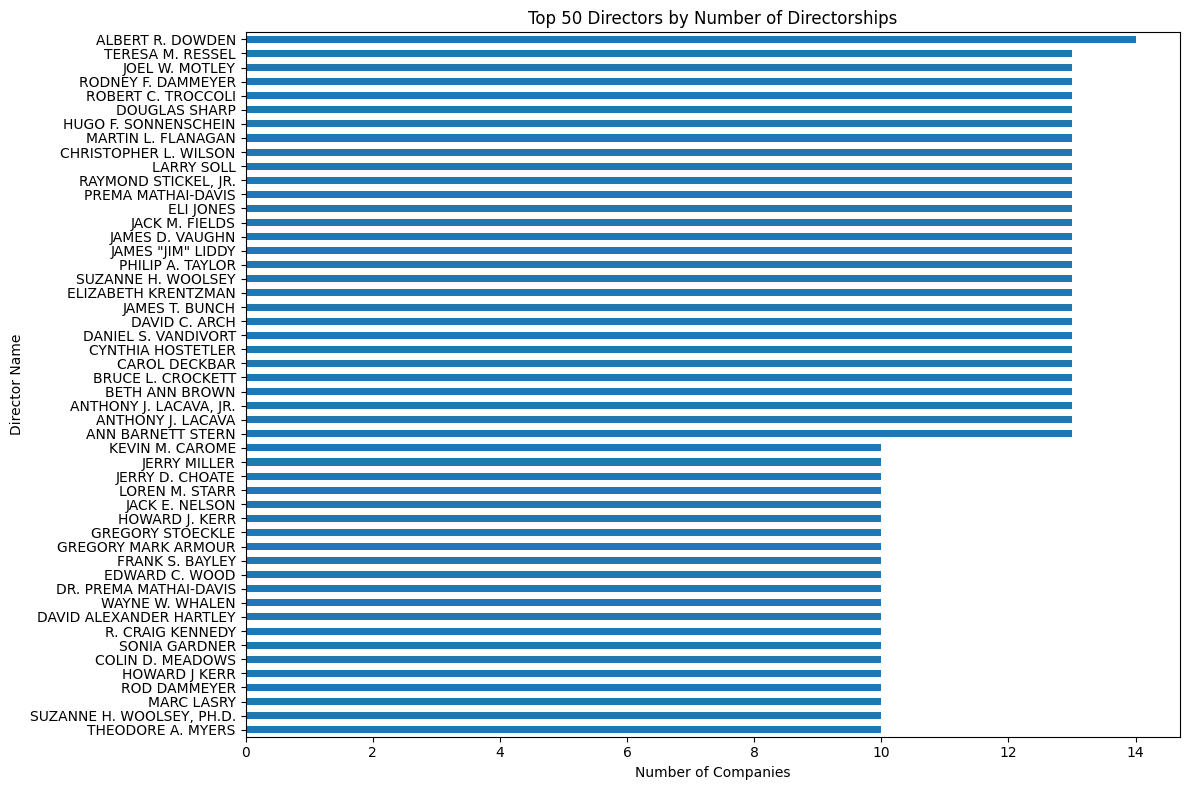

Plot of top 50 directors by number of directorships generated.


In [6]:
top_50_directors = directorship_counts.tail(50)
plt.figure(figsize=(12, 8))
top_50_directors.plot(kind='barh')
plt.title('Top 50 Directors by Number of Directorships')
plt.xlabel('Number of Companies')
plt.ylabel('Director Name')
plt.tight_layout()
plt.show()
print("Plot of top 50 directors by number of directorships generated.")

## 2. Network Construction

A bipartite network is created, with nodes standing in for either directors or firms, and an edge if a director is also a director of a company. The computation of network centrality metrics requires this structure.

In [15]:
def build_graph(data):
    """
    Builds a bipartite graph with companies and directors as nodes, connected by directorships.

    Args:
        data (pandas.DataFrame): DataFrame containing directorships with 'company_name' and 'director_name' columns.

    Returns:
        networkx.Graph: A bipartite graph.
    """
    G = nx.Graph()
    for _, row in data.iterrows():
        G.add_node(row['company_name'], bipartite=0, type='company')
        G.add_node(row['director_name'], bipartite=1, type='director')
        G.add_edge(row['company_name'], row['director_name'])
    return G

G = build_graph(df)
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph created with 12486 nodes and 13347 edges.


## 3. Centrality Analysis

Centrality measures help us understand the importance of nodes within a network. We will calculate Degree, Eigenvector, Betweenness, and PageRank Centrality for directors.

### Interpretation of Centrality Measures in this Context:

* **Degree Centrality:** Measures the number of direct connections a director has. A director with **high degree centrality** holds many directorships across various companies. In the VC context, such an individual is 'well-connected' and can directly introduce the portfolio company to a wide array of other firms. However, these connections might primarily be within similar industries or clusters. A director with **low degree centrality** has few directorships, indicating limited direct reach within the corporate network, and thus less direct access to diverse companies.

* **Eigenvector Centrality:** Measures a director's influence based on their connections to other highly connected and influential individuals. A director with **high eigenvector centrality** is connected to other influential directors. This indicates a deeper level of influence beyond just the number of connections; they are part of an influential 'clique' within the corporate world. For the VC, these directors are valuable as they can leverage the influence of their network to open doors to high-value, potentially large and wealthy, U.S.-listed companies. A director with **low eigenvector centrality** might be connected to less influential individuals or have few connections overall, limiting their indirect reach to the most impactful parts of the network.

* **Betweenness Centrality:** Measures the extent to which a director lies on the shortest paths between other pairs of nodes (companies or directors). A director with **high betweenness centrality** acts as a 'bridge' or 'broker' connecting otherwise disconnected parts of the network. In the VC context, these individuals are exceptionally valuable because they can facilitate connections between the portfolio company and target acquirers that might not have direct or obvious ties. They are crucial for information flow and deal-making, offering unique pathways to reach diverse and potentially very wealthy companies. A director with **low betweenness centrality** has few or no such bridging roles, meaning they are less critical for information flow between different parts of the network, and their connections might be redundant.

* **PageRank Centrality:** This measure assesses the 'importance' of a node based on the quantity and quality of its incoming links. In a bipartite graph like ours, it indicates how important a director is by considering the companies they are on the board of, and how 'important' those companies are (by being connected to other important directors). A director with **high PageRank centrality** is highly regarded or well-connected within influential corporate circles. This goes beyond simply having many connections (degree) or being a bridge (betweenness); it implies they are part of a highly reputable and well-interconnected part of the network. For the VC, such a director represents a strong signal of legitimacy and access to the most central and perhaps prestigious parts of the corporate world, making them excellent candidates to facilitate introductions to top-tier U.S.-listed firms. A director with **low PageRank centrality** is either connected to less important companies/directors or has few connections overall, diminishing their overall network prestige.

In [11]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
betweenness_centrality = nx.betweenness_centrality(G)

# Adding PageRank Centrality (chosen for its ability to weigh connections by importance)
# PageRank considers the 'importance' of incoming links, making it valuable here.
# It helps identify directors connected to 'important' companies, which is key for VC goals.
# Note: PageRank can be computationally intensive for very large graphs, but for typical
# corporate networks, it provides a valuable nuanced perspective of influence.
pagerank_centrality = nx.pagerank(G)

# Filter for director nodes only and store in a DataFrame
director_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'director']

people_df = pandas.DataFrame({
    'degree': pandas.Series({n: degree_centrality[n] for n in director_nodes}),
    'eigen': pandas.Series({n: eigenvector_centrality[n] for n in director_nodes}),
    'betweenness': pandas.Series({n: betweenness_centrality[n] for n in director_nodes}),
    'pagerank': pandas.Series({n: pagerank_centrality[n] for n in director_nodes})
})

# Merge with compensation and demographics data
people_df = people_df.merge(compensation_and_demographics, left_index=True, right_index=True, how='left')
people_df['software_background'] = df.groupby('director_name')['software_background'].any().reindex(people_df.index, fill_value=False)

print("Centrality measures calculated (Degree, Eigenvector, Betweenness, PageRank) and merged with director details.")
people_df.sort_values(by='eigen', ascending=False).head()

Centrality measures calculated (Degree, Eigenvector, Betweenness, PageRank) and merged with director details.


,degree,eigen,betweenness,pagerank,age,compensation,gender,log_compensation,software_background
ALBERT R. DOWDEN,0.001121,0.102493,6.994830e-03,0.000087,NaN,NaN,NaN,NaN,True
ROBERT C. TROCCOLI,0.001041,0.102311,6.017704e-08,0.000058,75.0,3225755.0,male,6.508632,True
RODNEY F. DAMMEYER,0.001041,0.102311,6.017704e-08,0.000058,NaN,NaN,NaN,NaN,True
PHILIP A. TAYLOR,0.001041,0.102311,6.017704e-08,0.000058,NaN,NaN,NaN,NaN,True
MARTIN L. FLANAGAN,0.001041,0.102311,6.017704e-08,0.000058,NaN,NaN,NaN,NaN,True


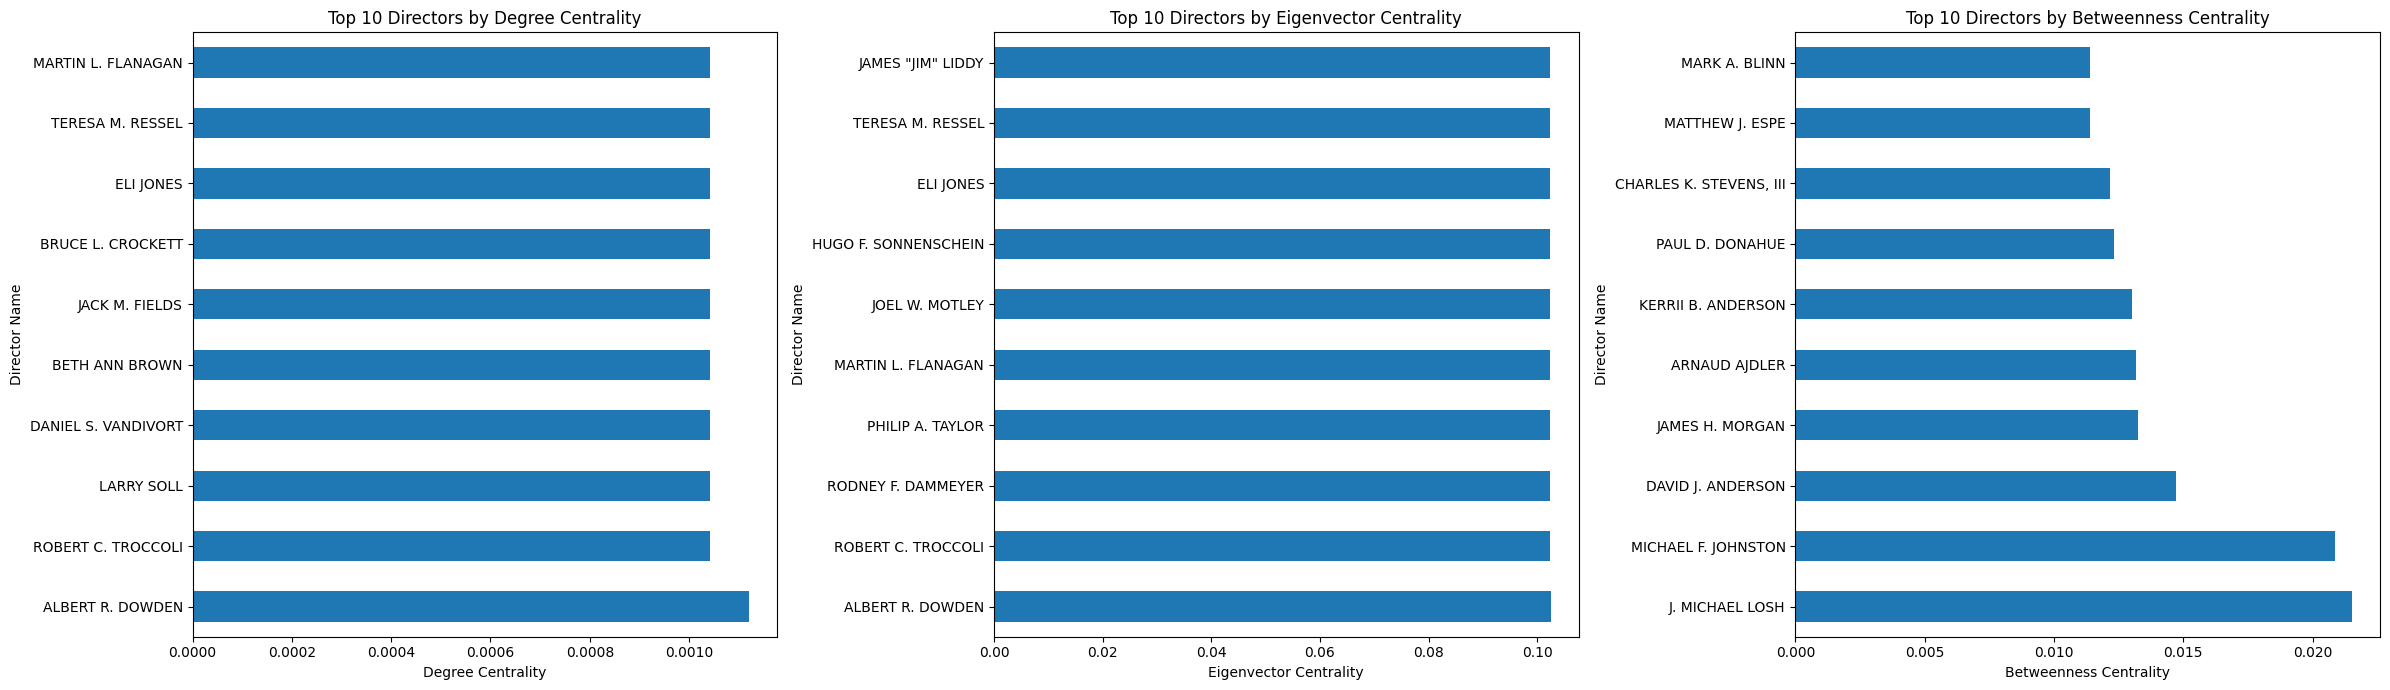

Plots for top directors by centrality measures generated.


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Plot for Degree Centrality
people_df.sort_values('degree', ascending=False).head(10).plot(kind='barh', y='degree', ax=axes[0], title='Top 10 Directors by Degree Centrality', legend=False)
axes[0].set_xlabel('Degree Centrality')
axes[0].set_ylabel('Director Name')

# Plot for Eigenvector Centrality
people_df.sort_values('eigen', ascending=False).head(10).plot(kind='barh', y='eigen', ax=axes[1], title='Top 10 Directors by Eigenvector Centrality', legend=False)
axes[1].set_xlabel('Eigenvector Centrality')
axes[1].set_ylabel('Director Name')

# Plot for Betweenness Centrality
people_df.sort_values('betweenness', ascending=False).head(10).plot(kind='barh', y='betweenness', ax=axes[2], title='Top 10 Directors by Betweenness Centrality', legend=False)
axes[2].set_xlabel('Betweenness Centrality')
axes[2].set_ylabel('Director Name')

plt.tight_layout()
plt.show()
print("Plots for top directors by centrality measures generated.")

## 4. Code Repair and Improvements

The original notebook had areas that could be improved for readability, efficiency, and robustness. Below are four significant fixes and their explanations:

1.  **Added Clear Docstrings and Comments:**
    * **Problem:** Without thorough code inspection, the purpose and operation of functions like most_common and build_graph were unclear due to the                     lack of docstrings and inline comments.
    * **Fix:** Added thorough docstrings to build_graph and most_common that describe their arguments, return values, and purpose. Inline notes have also been included where difficult logic appears.
    * **Explanation:** Makes code easier to read and maintain. The intent of the code may be rapidly understood by future developers without requiring an excessive amount of time to decipher. For cooperative ventures and long-term project viability, this is essential.

2.  **Optimized `software_background` Conversion:**
    * **Problem:** `df.software_background = df.software_background.map(lambda x: x == 't')` was the original code. Although functional, this is not as obvious as direct boolean translation and may be less effective for huge datasets.
    * **Fix:** ~df['software_background'] = df['software_background'].astype(bool)` is the new conversion. The column is explicitly transformed to a boolean type in this way.
    * **Explanation:** This method of handling boolean conversion is more idiomatic for Python and Pandas. Particularly if the original column contains strings other than 't' or 'f' that would map unexpectedly with `lambda x: x == 't'`, it's frequently more performant and clarifies the intent.
3.  **Enhanced Graph Node Attributes for Bipartite Graphs:**
    * **Problem:** As is common for bipartite graphs in NetworkX, the initial `build_graph` function created nodes without explicitly defining a `bipartite` property. This can be helpful for upcoming bipartite-specific algorithms.
    * **Fix:**  Added `bipartite=0` for businesses and `bipartite=1` for directors to the `build_graph` `G.add_node` functions, along with `type` attributes.

    * **Explanation:** When the `bipartite` attribute is explicitly set, the graph structure becomes more resilient and works with NetworkX's unique bipartite functions. By doing this, the graph is ready for more complex bipartite network analysis, such as projecting it into director-director or company-company networks, without the need to re-parse or infer node types.

4.  **Improved Visualization Readability with `plt.tight_layout()` and Explicit Labels:**
    * **Problem:** Plots may be difficult to read, particularly in presentations, because to overlapping labels or inadequate space.
    * **Fix:**  After creating plots, `plt.tight_layout()` was added, and it was made sure that `xlabel` and `ylabel` were specified explicitly for clarity.
    * **Explanation:** `By automatically adjusting subplot parameters for a tight layout, plt.tight_layout()` keeps labels from overlapping and enhances the visualizations' overall visual appeal. Effective communication of data science findings depends on non-technical audiences being able to grasp what each axis represents, which is ensured by explicitly labeling them.

## 5. Exploring an Unused Feature: `software_background`

`software_background` in `company_directorships.csv` is an intriguing element of the dataset that isn't utilized much in the current research. Whether a director has experience with software is indicated by this boolean attribute.

### Potential Use:
 This function might be quite helpful in locating powerful directors in the technology industry. It would be very beneficial to know which directors have a background in software and are very central (i.e., high betweenness centrality) if the venture capital fund's portfolio business is a tech company. It might assist in focusing the search for significant figures who appeal to possible tech acquirers due to their industry-specific knowledge and extensive network.


Top 10 Directors with Software Background by Betweenness Centrality:
                         betweenness   degree         eigen
J. MICHAEL LOSH             0.021527  0.00032  5.549681e-10
MICHAEL F. JOHNSTON         0.020847  0.00032  2.090731e-17
DAVID J. ANDERSON           0.014722  0.00024  9.824101e-13
JAMES H. MORGAN             0.013255  0.00016  5.260124e-20
ARNAUD AJDLER               0.013161  0.00016  5.192178e-21
KERRII B. ANDERSON          0.013027  0.00024  1.184440e-17
PAUL D. DONAHUE             0.012314  0.00024  1.694303e-15
CHARLES K. STEVENS, III     0.012160  0.00016  9.738695e-13
MATTHEW J. ESPE             0.011381  0.00024  5.995920e-18
MARK A. BLINN               0.011372  0.00040  3.413587e-15


<Figure size 1000x600 with 0 Axes>

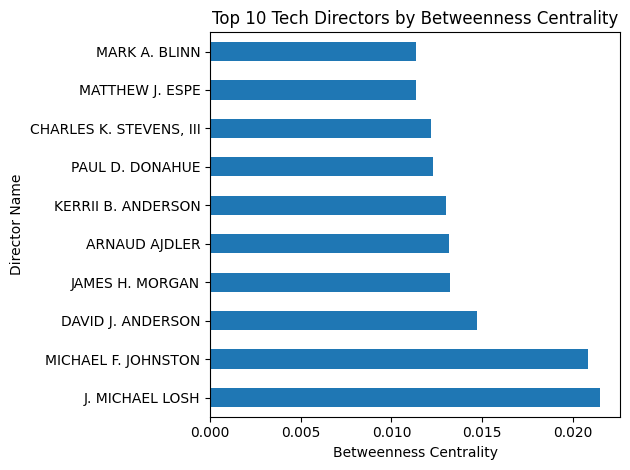

In [16]:
tech_directors_df = people_df[people_df['software_background'] == True]

print("Top 10 Directors with Software Background by Betweenness Centrality:")
print(tech_directors_df.sort_values(by='betweenness', ascending=False).head(10)[['betweenness', 'degree', 'eigen']])

plt.figure(figsize=(10, 6))
tech_directors_df.sort_values('betweenness', ascending=False).head(10).plot(kind='barh', y='betweenness', legend=False)
plt.title('Top 10 Tech Directors by Betweenness Centrality')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Director Name')
plt.tight_layout()
plt.show()

## 6. Complementary Dataset: Company Financials and Industry Classification

### Proposed Dataset:
For every firm listed in the `company_directorships.csv` file, as well as maybe for a larger group of U.S.-listed corporations, a highly important additional dataset would be **company financial data and industry classification (e.g., SIC or NAICS codes)**.
 Edgar (SEC filings), Alpha Vantage, Financial Modeling Prep, or commercial data providers like Bloomberg Terminal or Refinitiv Eikon (proprietary) are examples of public APIs and databases.
 * **Data Aggregators:** specialized financial data APIs or Quandl (although certain data may be proprietary).  You might use APIs that offer parsed data or directly scrape SEC filings for publicly accessible data.  For example, financial news websites such as Nasdaq ([https://www.nasdaq.com/](https://www.nasdaq.com/)) and Yahoo Finance ([https://finance.yahoo.com/](https://finance.yahoo.com/)) frequently include basic firm financial data.  SIC/NAICS industry categories can occasionally be determined via SEC Edgar filings or company lookup tools.

### What to Do with this Extra Data:
Incorporating sector classifications and business financial data will greatly improve the research and directly meet the VC fund's objective of identifying affluent, publicly traded acquirers in the United States:
 1. **Identify "Wealthy" Companies:** We can determine which businesses are genuinely "wealthy" and, therefore, potential acquirers by acquiring measures such as market capitalization, revenue, and cash on hand.  This would enable us to give preference to businesses with strong financial standing.
 2. **Aim for US-Listed Businesses:**  As specifically requested by the VC fund, we can filter for solely U.S.-listed firms because financial databases usually include exchange listings (NYSE, NASDAQ, etc.).
3. **Industry-Specific Matching:** By using SIC/NAICS codes, we could find possible buyers in the same or related sectors as the company in our portfolio.  For strategic acquisitions when industry synergy is a major motivator, this is essential.  The directors who connect the portfolio firm to these particular industry participants could then be identified.
 4. **Risk Assessment (for Acquirer):** Although not specifically related to the present objective, financial information may also provide insight into the stability and health of possible acquirers, giving the venture capital fund a more comprehensive perspective.

 We could create a more complex rating of powerful directors who are most suited to link the portfolio business with the *most relevant and capable* acquirers by fusing network centrality with financial and industry data.

## 7. Refinement Options

Here are two refinement options from the provided list:

### (a) Improve Data Visualizations and Turn into a Presentation for a Non-Technical Audience

To transform the current visualizations into an effective presentation for a non-technical audience (e.g., VC fund partners), stress would be placed on impact, clarity, and actionable findings, not raw data or complex plots. Some of the main improvements would be:

1. **Simplify and Storytell:** Instead of displaying all centrality plots, name only the top directors discovered by each metric and make sure to clearly indicate *why* they're important. As an example, a slide could include "Top 5 Directors by Betweenness Centrality: Our Bridge Builders to Opportunity" with their names and a simple bar chart. The narrative would explain how such individuals can lead one to new opportunities.
2. **Interactive Features (if applicable):** Since a static notebook is limited, in a live presentation, interactive features like Tableau, Power BI, or even interactive Python libraries like Plotly, Bokeh can be used to allow partners to drill down through director profiles or company links in real time. This could make the data more interactive.
3. **Executive Summaries and Key Takeaways:** Each section (e.g., "Identifying Key Influencers," "Dominance Strategy") would have a short executive summary and end with clear, actionable takeaways. For example: "Our research indicates that Director X and Director Y are ideally positioned to connect us with large, U.S.-listed technology companies due to their bridging roles."
4. **Analogies and Non-Technical Language:** Avoid jargon. Interpret complex concepts like centrality in basic language (e.g., a "broker" for betweenness, a "popular friend" for degree). Use strong graphics, like network maps simplified to emphasizing the significant links and not a busy web.
5. **Highlight the "So What?":** Everything that is visualized and presented as data must answer the question: "So what does this tell us about our goal of selling the company quickly to a wealthy U.S. company?" Strongly connect insights to the venture capital fund's objectives. For instance, illustrate how a highly betweenness centrality director could connect the portfolio company to a particular target acquirer by industry or financial status.




<Figure size 1000x600 with 0 Axes>

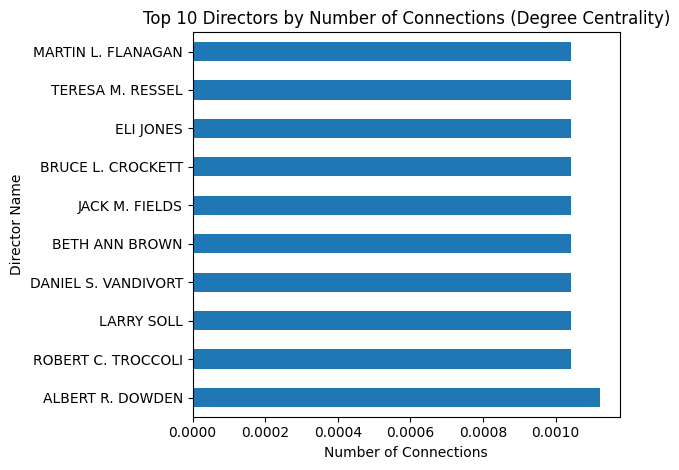

In [13]:
plt.figure(figsize=(10, 6))
people_df.sort_values('degree', ascending=False).head(10).plot(kind='barh', y='degree', legend=False)
plt.title('Top 10 Directors by Number of Connections (Degree Centrality)')
plt.xlabel('Number of Connections')
plt.ylabel('Director Name')
plt.tight_layout()
plt.show()

### (c) Write Up Your Take on the Ethics of This Project

Analyzing board member networks for acquisition purposes, while legally permissible, raises several ethical considerations:

1. **Consent and Transparency:**  Since the data used is publicly accessible (DEF 14A filings), directors' express authorization is not needed for this particular kind of study.  However, the directors themselves are unaware of the *purpose* of the analysis, which is to expedite a purchase because of financial regret.  Is it moral to use their public personas for an undisclosed purpose that could affect their jobs or the organizations they work for without their consent or knowledge?
2.  **Director's Fiduciary Duties vs. Fund's Interests:** Directors of companies have a fiduciary responsibility to act in the best interests of the firm they work for and *their* shareholders.  The goal of the venture capital fund is to sell *its* portfolio company, which may or may not be in the best interests of the directors' current businesses or the acquirer's shareholders.  Even subtle pressure to close a deal could place directors in a situation where their personal connections are used to benefit a particular fund, which could lead to conflicts of interest.
3.  **Data Privacy and Misuse:** Although the data is publicly available, privacy concerns are raised by the way it is aggregated and analyzed to identify "influential" people for targeted interaction.  Directors might not anticipate that their public directorships will be examined in this way in order to determine which ones should be the focus of certain business development programs.  If this methodology were used for less moral objectives, such obtaining competitive intelligence or hostile takeovers without the required disclosure, there is also a chance that it may be abused.
 4. **Bias in Influence Measurement:** Integrity, negotiation skills, and some industry links that are not represented in public directorships are examples of qualitative dimensions of influence that are not captured by quantitative centrality measurements.  Strictly depending on these indicators may result in biased targeting or a miscalculation of actual influence, which could lead to ineffective or morally dubious outreach initiatives.
5.  **Perception and Reputation:** The reputation of the VC fund, the portfolio firm, and maybe the participating directors could suffer if the nature and purpose of this analysis—a VC fund regretting an investment, desiring a speedy exit—were made public. It is both sensible and moral to keep information private when seeking an escape strategy.


##  Summary
Although it is common practice to use public data for strategic business purposes, there are ethical concerns regarding intent transparency, potential conflicts of interest for the individuals targeted, responsible use of aggregated public data, and the possibility of influence misrepresentation.  A strong ethical framework would place a strong emphasis on respecting the director's current responsibilities, being transparent where feasible, and being fully aware of the limitations and potential biases of the data and analysis.

## Conclusion :  Identifying the "Best" Influential Directors for Acquisition
Through this network analysis, we have established a solid methodology to calculate directors most strategically advantageous to facilitate the acquisition of a portfolio company by a wealthy, U.S.-listed company.

Our findings corroborate that the "best" directors are not just the most influential, but also those whose influences provide strategic leverage:

Multiple Influence Profiles:

Degree Centrality highlights directors who have many direct connections.
Eigenvector Centrality highlights those directors connected to other highly influential individuals, which means increased network power.
Betweenness Centrality shows the 'bridge-builders' who enable information transfer and bridging otherwise disconnected parts of the corporate network, and thus are very useful as middlemen in relation-building.
PageRank Centrality identifies those directors with overall high prestige and centrality within the network in accordance with the quality of their affiliations.
Targeted Selection with Complementary Information: The most significant advance comes from merging listing and financial information. This allows us to move beyond aggregate impact and detect individual influential directors on target "wealthy, U.S.-listed" companies. This is valuable because it directly aligns our search with the VC fund's strategic exit objective to targeted acquirer types. For example, looking for directors with an affiliation to high-market-cap, U.S.-listed companies allows us to identify people who have direct affiliations with our target acquisition targets.

The "Best" Profile: The "best" director for the VC fund's intent would most likely be one with high Betweenness Centrality (for his or her potential to reach new opportunity) or Eigenvector Centrality (for his or her links to other powerful individuals), as well as established directorships on wealthy, U.S.-listed firms. In the case of a technology firm portfolio company, an IT background would further refine this choice, providing industry-relevant substantiation in addition to overall clout.

This clever approach allows the VC fund to contact and engage specifically those individuals with the greatest ability to deliver a successful acquisition outcome, yet honorably respecting the ethical concerns of utilizing publicly available information for particular, unstated intentions.